In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [2]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


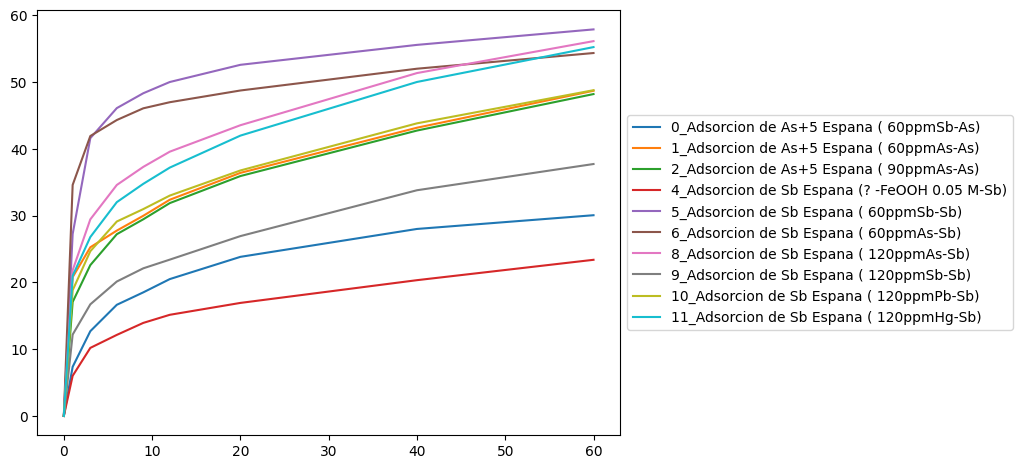

In [3]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [4]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [5]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [6]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [7]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


In [8]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, lattice_class, n_calls=200, n_simulations_avg=5):
        self.exp_data = np.array(exp_data)
        self.param_ranges = param_ranges
        self.lattice_class = lattice_class
        self.n_calls = n_calls
        self.n_simulations_avg = n_simulations_avg
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = None
        self.time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])  # o parametrizable

        if len(self.exp_data) != len(self.time_array):
            raise ValueError("La longitud de exp_data debe coincidir con la longitud de time_array.")

    def loss_function(self, params):
        param_dict = {name: val for name, val in zip(self.param_ranges.keys(), params)}

        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {
                "e_ads": param_dict["e_ads"],
                "e_int_abs": param_dict.get("e_int_abs", 0)
            }
        if 'e_des' in param_dict:
            processes["desorption"] = {
                "e_des": param_dict["e_des"],
                "e_int_des": param_dict.get("e_int_des", 0)
            }
        if 'e_diff' in param_dict:
            processes["diffusion"] = {
                "e_diff": param_dict['e_diff'],
                "e_int_diff": param_dict.get('e_int_diff', 0)
            }

        all_simulated_occupancies = []

        for _ in range(self.n_simulations_avg):
            lattice = self.lattice_class(int(param_dict['lattice_size']))
            kmc_model = KineticMonteCarlo(
                lattice=lattice,
                T=param_dict['T'],
                processes=processes,
                time_array=self.time_array
            )
            kmc_model.run_simulation()
            simulated_run_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
            all_simulated_occupancies.append(simulated_run_data)

        if not all_simulated_occupancies:
            return float('inf')

        avg_simulated_data = np.mean(all_simulated_occupancies, axis=0)
        error = np.mean((avg_simulated_data - self.exp_data) ** 2)

        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        if self.progress_bar:
            self.progress_bar.set_postfix({
                "Mejor error": f"{self.best_error:.6f}",
                "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
            })
            self.progress_bar.update(1)

        return error

    def optimize(self):
        self.progress_bar = tqdm(
            total=self.n_calls,
            desc="🚀 Optimización Bayesiana",
            position=0,
            ncols=100,
            unit="eval"
        )

        space = []
        for param_name, prange in self.param_ranges.items():
            if param_name == 'lattice_size':
                space.append(Integer(prange[0], prange[1], name=param_name))
            else:
                space.append(Real(prange[0], prange[1], name=param_name))

        start_time = time.time()

        result = gp_minimize(
            func=self.loss_function,
            dimensions=space,
            n_calls=self.n_calls,
            random_state=42
        )
        self.progress_bar.close()

        end_time = time.time()
        print("\n✅ Optimización completada")
        if self.best_params:
            print("🔹 Parámetros óptimos encontrados:", self.best_params)
            print(f"🔹 Error mínimo (MSE) encontrado: {self.best_error:.6f}")
        else:
            print("⚠️ No se encontraron parámetros óptimos.")
            print("   Últimos parámetros:", {s.name: v for s, v in zip(space, result.x)})
            print(f"   Último error: {result.fun:.6f}")

        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if not self.best_params:
            print("ℹ️ No se encontraron parámetros óptimos para ejecutar el modelo final.")
            return

        processes = {}
        if 'e_ads' in self.best_params:
            processes["adsorption"] = {
                "e_ads": self.best_params["e_ads"],
                "e_int_abs": self.best_params.get("e_int_abs", 0)
            }
        if 'e_des' in self.best_params:
            processes["desorption"] = {
                "e_des": self.best_params["e_des"],
                "e_int_des": self.best_params.get("e_int_des", 0)
            }
        if 'e_diff' in self.best_params:
            processes["diffusion"] = {
                "e_diff": self.best_params["e_diff"],
                "e_int_diff": self.best_params.get("e_int_diff", 0)
            }


        print(f"\n⚙️ Ejecutando simulación final con los mejores parámetros: {self.best_params}")
        lattice = self.lattice_class(int(self.best_params['lattice_size']))
        kmc_model = KineticMonteCarlo(
            lattice=lattice,
            T=self.best_params['T'],
            processes=processes,
            time_array=self.time_array
        )
        kmc_model.run_simulation()

        simulated_final_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
        print("📊 Datos experimentales:", self.exp_data)
        print("📈 Datos simulados:", simulated_final_data)
        final_error = np.mean((simulated_final_data - self.exp_data) ** 2)
        print(f" MSE final (verificación): {final_error:.6f}")

Ocupación final: 17.726734693877553
Energía final: 13734.848000007853
Mean Squared Error (MSE): 68.92393829531679
{'adsorption': 95812, 'desorption': 3483, 'diffusion': 1}


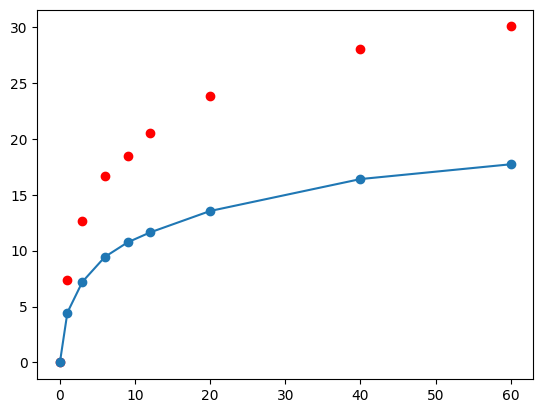

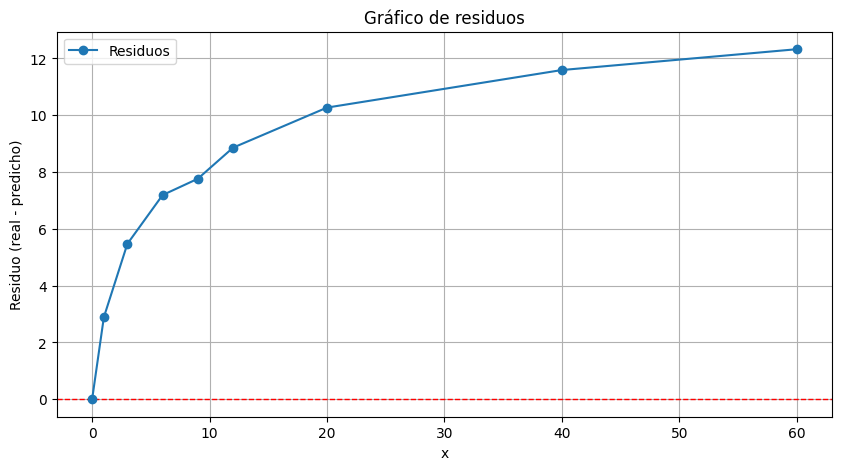

In [9]:

processes = {
    "adsorption": {"e_ads": 0.098, "e_int_abs": 0.055},
    "desorption": {"e_des": 0.17, "e_int_des": 0.17},
    "diffusion": {"e_diff": 0.4, "e_int_diff": 0.1}
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 700

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[0, :9].to_numpy(),color = 'red', label='Experimental data')
mse = np.mean((data.iloc[0, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)

# Cálculo de residuos
residuos = data.iloc[0, :9].to_numpy() - np.array(list(simulated_data)) 

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')
plt.title('Gráfico de residuos')
plt.xlabel('x')
plt.ylabel('Residuo (real - predicho)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
resultados_opt = pd.read_csv('resultados_optimizacion.csv')
resultados_opt

,experiment_index,best_error,e_ads,e_int_abs,e_des,e_int_des,e_diff,e_int_diff,lattice_size,T
0,0,0.102170,0.081506,0.042231,0.272000,0.068302,0.160000,0.160000,765,300.652977
1,1,1.915544,0.040199,0.042529,0.272000,0.068000,0.640000,0.108811,600,300.000000
2,2,0.661106,0.047140,0.038715,0.243444,0.267271,0.586739,0.150995,737,300.008465
3,3,0.037399,0.115559,0.077452,0.099043,0.166115,0.160000,0.118336,783,300.000000
4,4,0.109109,0.087042,0.051374,0.147142,0.149227,0.593463,0.085338,658,300.623917
5,5,21.258396,0.039200,0.032714,0.272000,0.203394,0.471041,0.105379,600,300.365156
6,6,39.797460,0.039200,0.033840,0.181385,0.145380,0.388395,0.040954,600,300.804083
7,7,5.697875,0.039200,0.032803,0.272000,0.148845,0.206789,0.160000,600,300.198780
8,8,0.843838,0.039200,0.035252,0.272000,0.272000,0.640000,0.068713,727,300.644217
9,9,0.596735,0.080085,0.040421,0.272000,0.111082,0.187424,0.160000,600,300.358782


In [11]:
# Extraer cada columna de resultados_opt como listas
best_error = resultados_opt['best_error'].tolist()
e_ads = resultados_opt['e_ads'].tolist()
e_int_abs = resultados_opt['e_int_abs'].tolist()
e_des = resultados_opt['e_des'].tolist()
e_int_des = resultados_opt['e_int_des'].tolist()
e_diff = resultados_opt['e_diff'].tolist()
e_int_diff = resultados_opt['e_int_diff'].tolist()
lattice_size_opt = resultados_opt['lattice_size'].tolist()
T_opt = resultados_opt['T'].tolist()



In [12]:
data.iloc[0]['Fuente(experimento)']


'0_Adsorcion de As+5 Espana ( 60ppmSb-As)'

Mean Squared Error (MSE): 0.15884687005399176
{'adsorption': 215277, 'desorption': 77, 'diffusion': 4173}


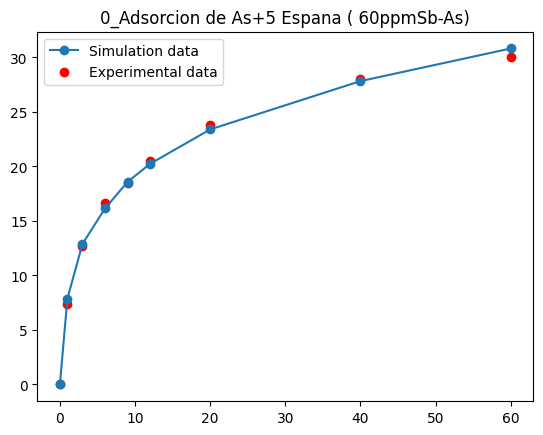

Mean Squared Error (MSE): 2.6247559393078093
{'adsorption': 227692, 'desorption': 12, 'diffusion': 0}


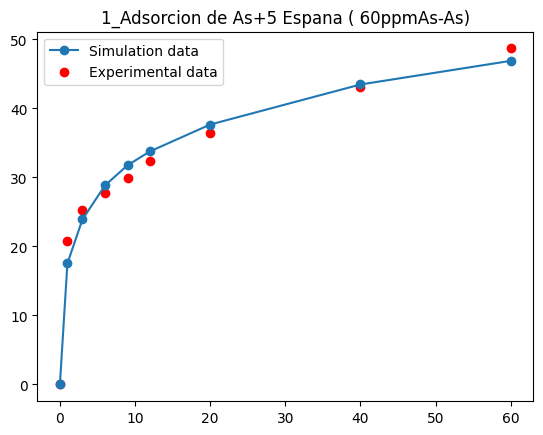

Mean Squared Error (MSE): 0.8243799154422505
{'adsorption': 341760, 'desorption': 53, 'diffusion': 0}


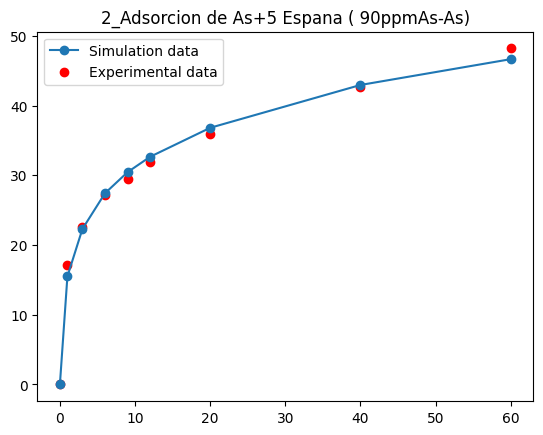

Mean Squared Error (MSE): 0.30549024427904686
{'adsorption': 32656, 'desorption': 44640, 'diffusion': 4518}


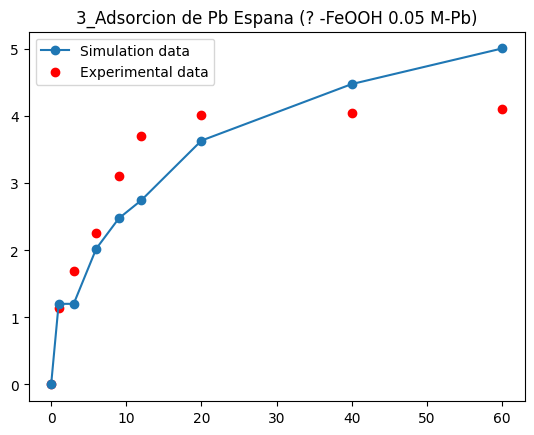

Mean Squared Error (MSE): 0.1403488227119202
{'adsorption': 112524, 'desorption': 5561, 'diffusion': 0}


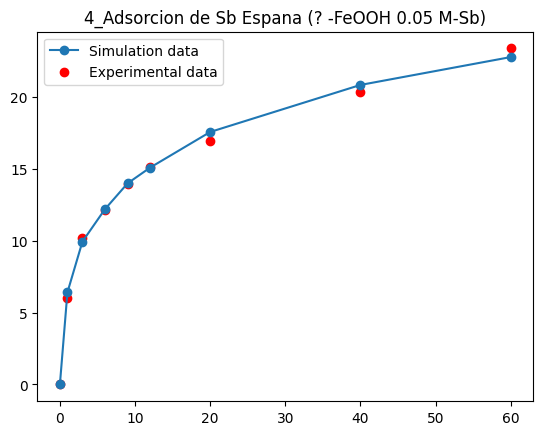

Mean Squared Error (MSE): 22.152264010886807
{'adsorption': 381161, 'desorption': 4, 'diffusion': 0}


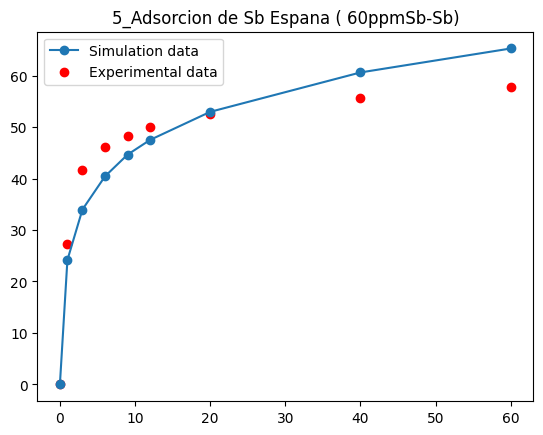

Mean Squared Error (MSE): 41.556527718288415
{'adsorption': 358586, 'desorption': 256, 'diffusion': 0}


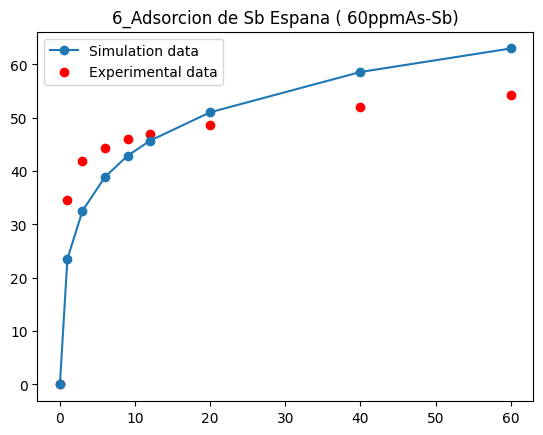

Mean Squared Error (MSE): 5.971459083986425
{'adsorption': 378289, 'desorption': 5, 'diffusion': 105}


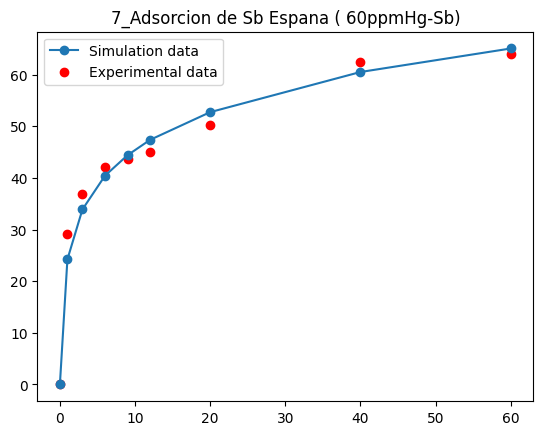

Mean Squared Error (MSE): 1.1818406172788838
{'adsorption': 432717, 'desorption': 11, 'diffusion': 0}


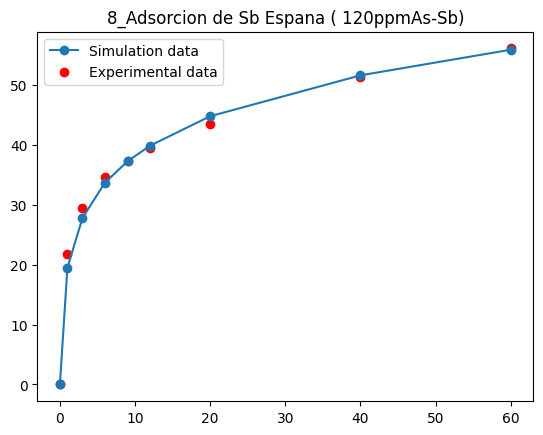

Mean Squared Error (MSE): 0.8703030561396489
{'adsorption': 166082, 'desorption': 35, 'diffusion': 850}


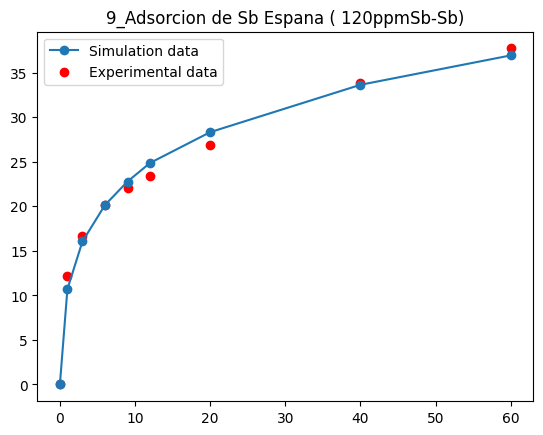

Mean Squared Error (MSE): 0.789920233442706
{'adsorption': 252979, 'desorption': 25, 'diffusion': 0}


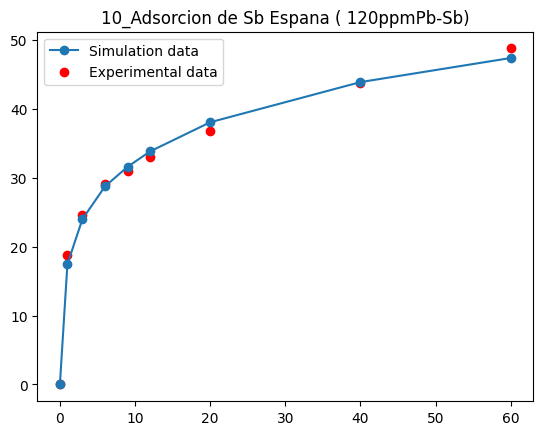

Mean Squared Error (MSE): 1.1871247961807363
{'adsorption': 410470, 'desorption': 31, 'diffusion': 132}


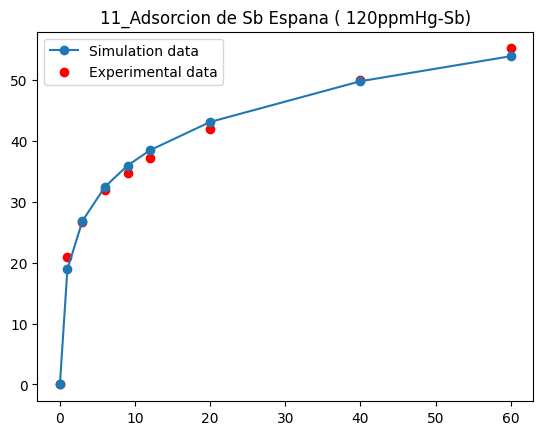

In [19]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
errors_kmc = []

for i in range(len(resultados_opt)):

    processes = {
        "adsorption": {"e_ads": e_ads[i], "e_int_abs": e_int_abs[i]},
        "desorption": {"e_des": e_des[i], "e_int_des": e_int_des[i]},
        "diffusion": {"e_diff": e_diff[i], "e_int_diff": e_int_diff[i]}
    }
    T = T_opt[i]
    lattice_size = lattice_size_opt[i]


    lattice = HexagonalLattice(size=lattice_size) 


    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()


    simulated_data = occupancy.values()
    plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
    plt.scatter(time_array, data.iloc[i, :9].to_numpy(),color = 'red', label='Experimental data')
    mse = np.mean((data.iloc[i, :9].to_numpy() - np.array(list(simulated_data))) ** 2)

    errors_kmc.append(mse)
    print(f"Mean Squared Error (MSE): {mse}")
    print(kmc.events_count)
    plt.title(data.iloc[i]['Fuente(experimento)'])
    plt.legend()
    plt.show()

Experimento: 0_Adsorcion de As+5 Espana ( 60ppmSb-As)
  q_e = 31.2199 mg/g, k_n = 0.0381 1/min, n = 2.3974
  Error cuadrático medio (MSE): 0.0972


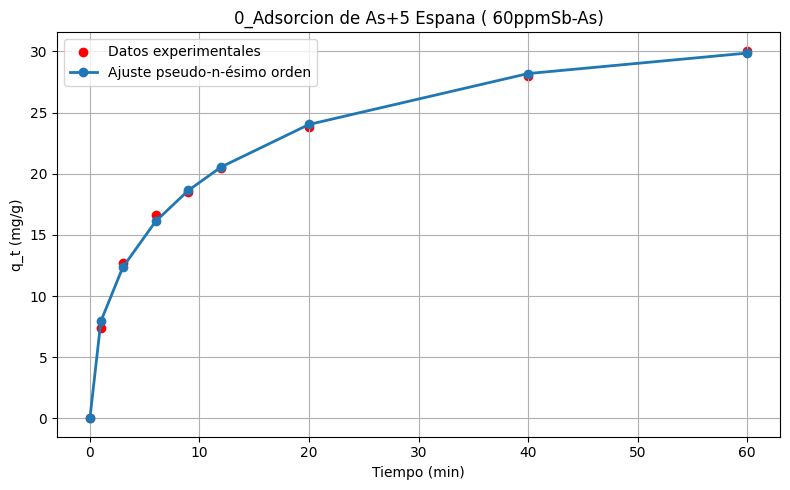

Experimento: 1_Adsorcion de As+5 Espana ( 60ppmAs-As)
  q_e = 252.5199 mg/g, k_n = 0.0000 1/min, n = 4.5234
  Error cuadrático medio (MSE): 0.9132


/var/folders/0j/wjdr50f52rs1fylv6znxjsbm0000gn/T/ipykernel_74036/3226252384.py:4: RuntimeWarning: invalid value encountered in power
  return q_e * (1 - np.exp(-k_n * t)) ** (1 / n)


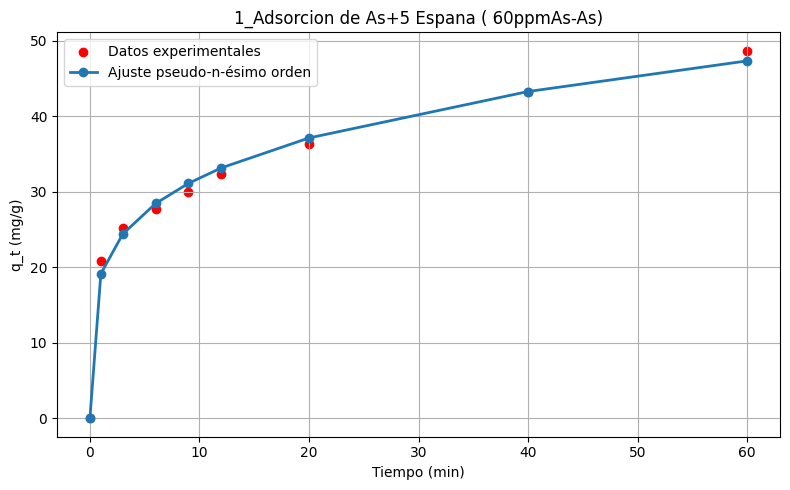

Error en el ajuste para el experimento 2: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Experimento: 3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
  q_e = 4.1684 mg/g, k_n = 0.1182 1/min, n = 1.4307
  Error cuadrático medio (MSE): 0.0308


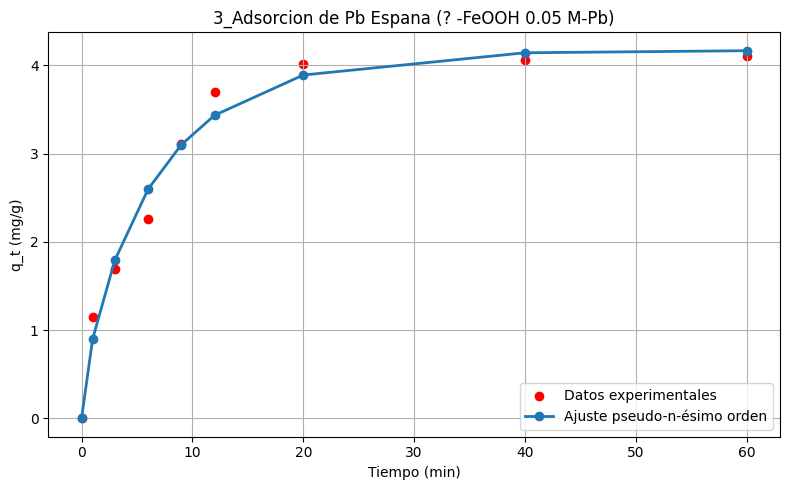

Experimento: 4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
  q_e = 28.6621 mg/g, k_n = 0.0118 1/min, n = 3.0845
  Error cuadrático medio (MSE): 0.1838


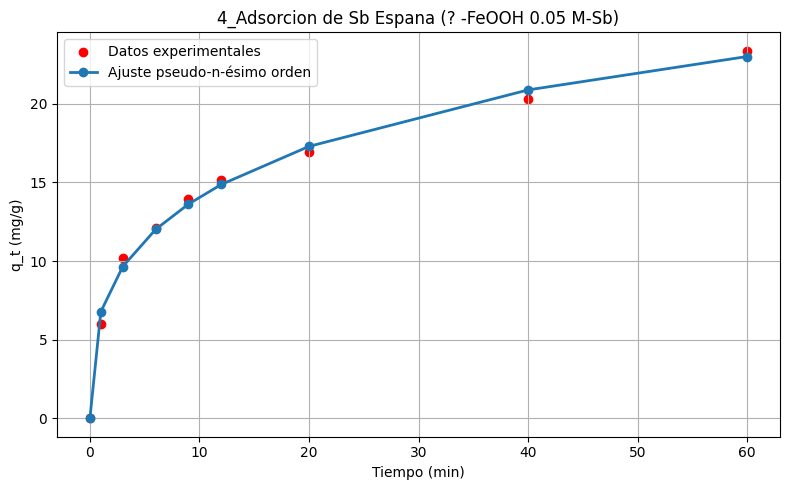

Experimento: 5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
  q_e = 56.2265 mg/g, k_n = 0.1033 1/min, n = 3.5471
  Error cuadrático medio (MSE): 2.1788


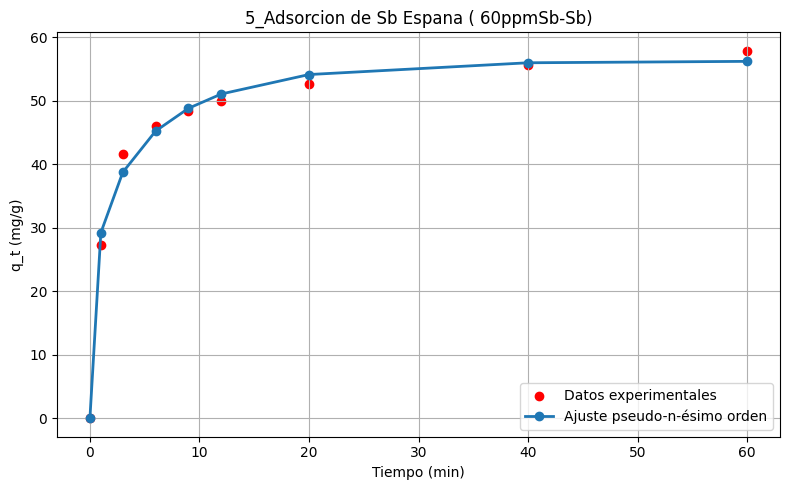

Experimento: 6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
  q_e = 55.3857 mg/g, k_n = 0.0251 1/min, n = 8.4136
  Error cuadrático medio (MSE): 0.5223


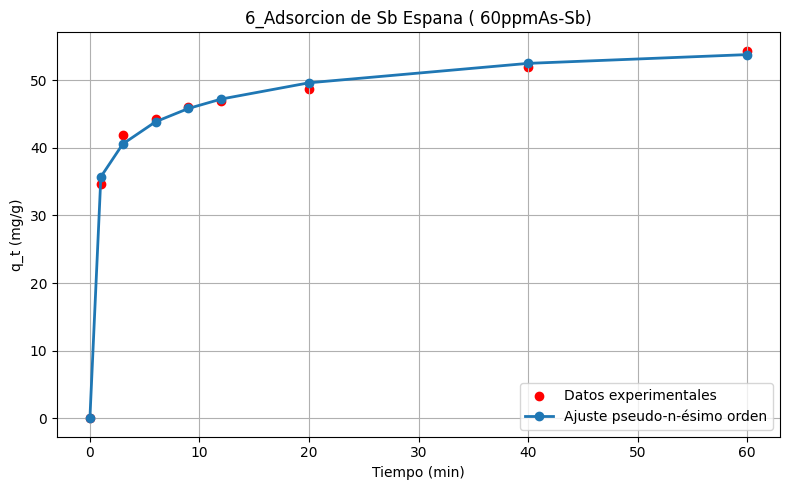

Experimento: 7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
  q_e = 286.8263 mg/g, k_n = 0.0000 1/min, n = 5.0747
  Error cuadrático medio (MSE): 2.1153


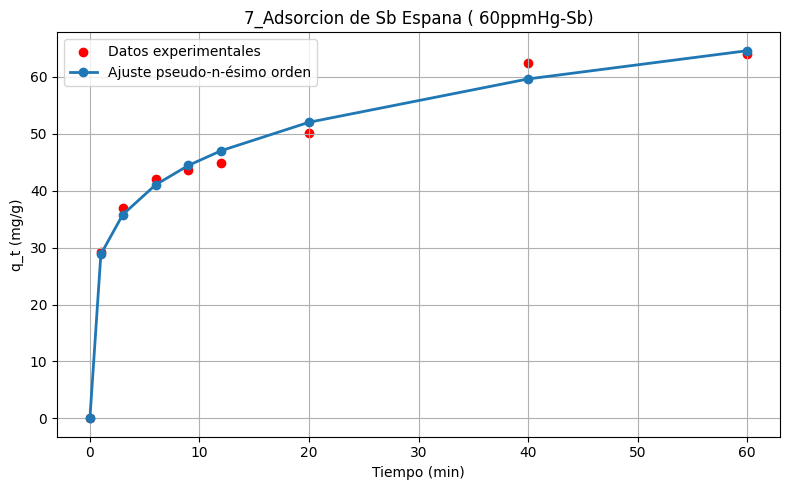

Experimento: 8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
  q_e = 80.8280 mg/g, k_n = 0.0037 1/min, n = 4.3975
  Error cuadrático medio (MSE): 0.2168


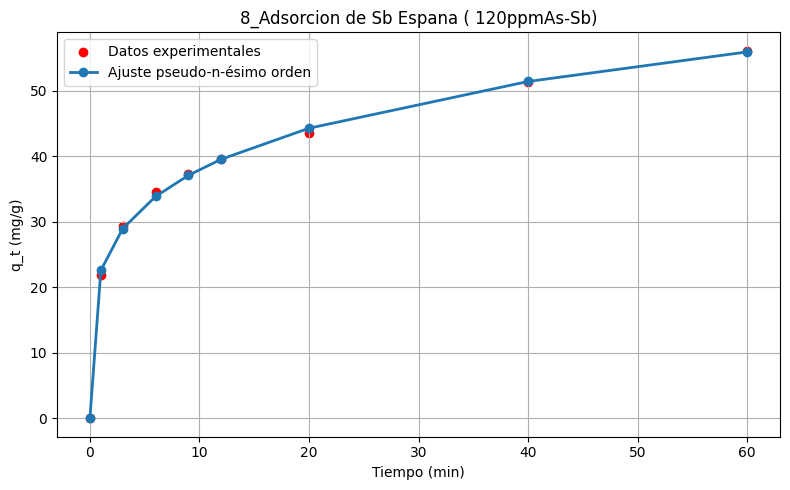

Experimento: 9_Adsorcion de Sb Espana ( 120ppmSb-Sb)
  q_e = 307.9274 mg/g, k_n = 0.0000 1/min, n = 3.6064
  Error cuadrático medio (MSE): 0.1414


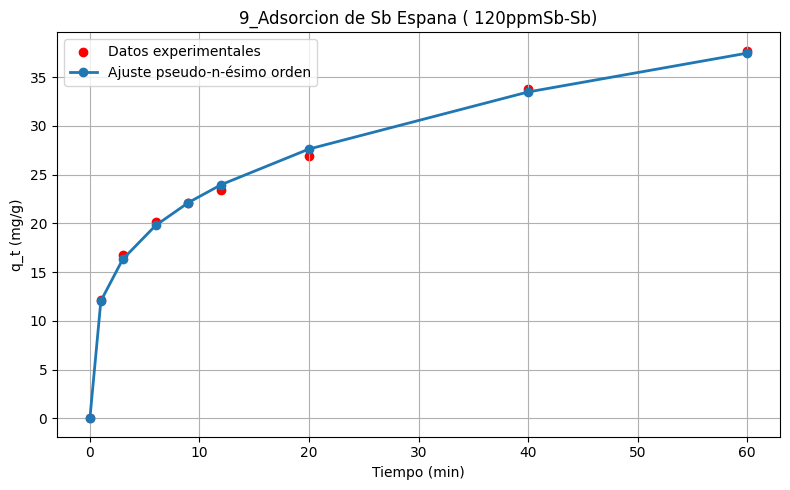

Error en el ajuste para el experimento 10: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Experimento: 11_Adsorcion de Sb Espana ( 120ppmHg-Sb)
  q_e = 325.0903 mg/g, k_n = 0.0000 1/min, n = 4.1821
  Error cuadrático medio (MSE): 0.0510


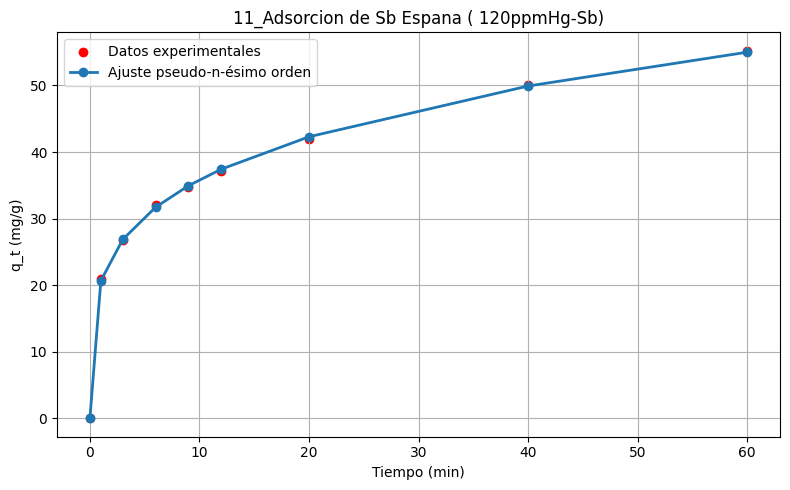

In [27]:
from scipy.optimize import curve_fit

def pseudo_n_order(t, q_e, k_n, n):
    return q_e * (1 - np.exp(-k_n * t)) ** (1 / n)

errors_curvefit = []

for i in range(len(data)):
    t_exp = time_array
    qt_exp = data.iloc[i, :9].to_numpy()

    # Ajuste de los datos experimentales al modelo pseudo-n-ésimo orden
    p0 = [max(qt_exp), 0.1, 2]
    try:
        params_opt, _ = curve_fit(pseudo_n_order, t_exp, qt_exp, p0=p0)
        q_e_fit, k_n_fit, n_fit = params_opt
        qt_fit = pseudo_n_order(t_exp, q_e_fit, k_n_fit, n_fit)

        print(f"Experimento: {data.iloc[i]['Fuente(experimento)']}")
        print(f"  q_e = {q_e_fit:.4f} mg/g, k_n = {k_n_fit:.4f} 1/min, n = {n_fit:.4f}")
        mse = np.mean((qt_exp - qt_fit) ** 2)
        print(f"  Error cuadrático medio (MSE): {mse:.4f}")
        errors_curvefit.append(mse)
        plt.figure(figsize=(8, 5))
        plt.scatter(t_exp, qt_exp, color='red', label='Datos experimentales')
        plt.plot(t_exp, qt_fit, marker='o', label='Ajuste pseudo-n-ésimo orden', linewidth=2)
        plt.title(data.iloc[i]['Fuente(experimento)'])
        plt.xlabel('Tiempo (min)')
        plt.ylabel('q_t (mg/g)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en el ajuste para el experimento {i}: {e}")
        errors_curvefit.append('no se pudo ajustar')




In [28]:
# Crear un DataFrame con los errores de KMC y curve fit
errores_df = pd.DataFrame({
    'error_kmc': errors_kmc[:len(errors_curvefit)],
    'error_curvefit': errors_curvefit
})
errores_df

,error_kmc,error_curvefit
0,0.158847,0.097221
1,2.624756,0.913245
2,0.824380,no se pudo ajustar
3,0.305490,0.030787
4,0.140349,0.183768
5,22.152264,2.17882
6,41.556528,0.522286
7,5.971459,2.115285
8,1.181841,0.216812
9,0.870303,0.141395


In [31]:
resultados_opt.iloc[5]


experiment_index      5.000000
best_error           21.258396
e_ads                 0.039200
e_int_abs             0.032714
e_des                 0.272000
e_int_des             0.203394
e_diff                0.471041
e_int_diff            0.105379
lattice_size        600.000000
T                   300.365156
Name: 5, dtype: float64

Ocupación final: 55.11000000000001
Energía final: 25269.342384003023
Mean Squared Error (MSE): 3.833589632316774
{'adsorption': 1019943, 'desorption': 632684}


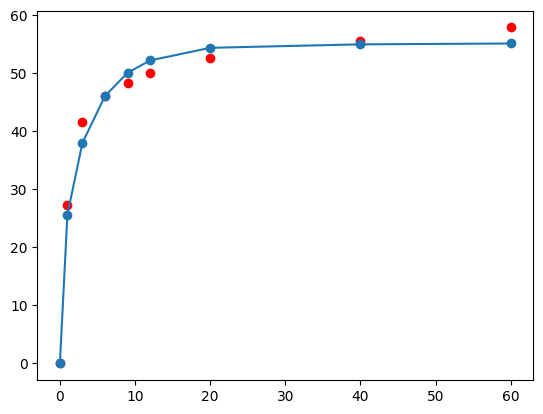

In [44]:

processes = {
    "adsorption": {"e_ads": 0.043, "e_int_abs": 0.032714},
    "desorption": {"e_des": 0.272000, "e_int_des": -0.034},
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 600

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[5, :9].to_numpy(),color = 'red', label='Experimental data')
mse = np.mean((data.iloc[5, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)


In [45]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm
import numpy as np
import time

class KMCModelOptimizer_2:
    def __init__(self, exp_data, param_ranges, lattice_class, n_calls=200, n_simulations_avg=5, initial_points=None):
        self.exp_data = np.array(exp_data)
        self.param_ranges = param_ranges
        self.lattice_class = lattice_class
        self.n_calls = n_calls
        self.n_simulations_avg = n_simulations_avg
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = None
        self.initial_points = initial_points or []
        self.time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

        if len(self.exp_data) != len(self.time_array):
            raise ValueError("La longitud de exp_data debe coincidir con la longitud de time_array.")

    def loss_function(self, params):
        param_dict = {name: val for name, val in zip(self.param_ranges.keys(), params)}

        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {
                "e_ads": param_dict["e_ads"],
                "e_int_abs": param_dict.get("e_int_abs", 0)
            }
        if 'e_des' in param_dict:
            processes["desorption"] = {
                "e_des": param_dict["e_des"],
                "e_int_des": param_dict.get("e_int_des", 0)
            }
        if 'e_diff' in param_dict:
            processes["diffusion"] = {
                "e_diff": param_dict['e_diff'],
                "e_int_diff": param_dict.get('e_int_diff', 0)
            }

        all_simulated_occupancies = []

        for _ in range(self.n_simulations_avg):
            lattice = self.lattice_class(int(param_dict['lattice_size']))
            kmc_model = KineticMonteCarlo(
                lattice=lattice,
                T=param_dict['T'],
                processes=processes,
                time_array=self.time_array
            )
            kmc_model.run_simulation()
            simulated_run_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
            all_simulated_occupancies.append(simulated_run_data)

        if not all_simulated_occupancies:
            return float('inf')

        avg_simulated_data = np.mean(all_simulated_occupancies, axis=0)
        error = np.mean((avg_simulated_data - self.exp_data) ** 2)

        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        if self.progress_bar:
            self.progress_bar.set_postfix({
                "Mejor error": f"{self.best_error:.6f}",
                "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
            })
            self.progress_bar.update(1)

        return error

    def _prepare_initial_points(self):
        x0 = []
        y0 = []
        param_order = list(self.param_ranges.keys())

        for point in self.initial_points:
            try:
                x_point = [point[param] for param in param_order]
                y_point = self.loss_function(x_point)
                x0.append(x_point)
                y0.append(y_point)
            except KeyError as e:
                print(f"⚠️ Clave faltante en punto inicial: {e}")
                continue

        return x0, y0

    def optimize(self):
        self.progress_bar = tqdm(
            total=self.n_calls,
            desc="🚀 Optimización Bayesiana",
            position=0,
            ncols=100,
            unit="eval"
        )

        space = []
        for param_name, prange in self.param_ranges.items():
            if param_name == 'lattice_size':
                space.append(Integer(prange[0], prange[1], name=param_name))
            else:
                space.append(Real(prange[0], prange[1], name=param_name))

        x0, y0 = self._prepare_initial_points()

        start_time = time.time()

        result = gp_minimize(
            func=self.loss_function,
            dimensions=space,
            n_calls=self.n_calls,
            x0=x0 if x0 else None,
            y0=y0 if y0 else None,
            random_state=42
        )

        self.progress_bar.close()
        end_time = time.time()

        print("\n✅ Optimización completada")
        if self.best_params:
            print("🔹 Parámetros óptimos encontrados:", self.best_params)
            print(f"🔹 Error mínimo (MSE) encontrado: {self.best_error:.6f}")
        else:
            print("⚠️ No se encontraron parámetros óptimos.")
            print("   Últimos parámetros:", {s.name: v for s, v in zip(space, result.x)})
            print(f"   Último error: {result.fun:.6f}")

        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if not self.best_params:
            print("ℹ️ No se encontraron parámetros óptimos para ejecutar el modelo final.")
            return

        processes = {}
        if 'e_ads' in self.best_params:
            processes["adsorption"] = {
                "e_ads": self.best_params["e_ads"],
                "e_int_abs": self.best_params.get("e_int_abs", 0)
            }
        if 'e_des' in self.best_params:
            processes["desorption"] = {
                "e_des": self.best_params["e_des"],
                "e_int_des": self.best_params.get("e_int_des", 0)
            }
        if 'e_diff' in self.best_params:
            processes["diffusion"] = {
                "e_diff": self.best_params["e_diff"],
                "e_int_diff": self.best_params.get("e_int_diff", 0)
            }

        print(f"\n⚙️ Ejecutando simulación final con los mejores parámetros: {self.best_params}")
        lattice = self.lattice_class(int(self.best_params['lattice_size']))
        kmc_model = KineticMonteCarlo(
            lattice=lattice,
            T=self.best_params['T'],
            processes=processes,
            time_array=self.time_array
        )
        kmc_model.run_simulation()

        simulated_final_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
        print("📊 Datos experimentales:", self.exp_data)
        print("📈 Datos simulados:", simulated_final_data)
        final_error = np.mean((simulated_final_data - self.exp_data) ** 2)
        print(f" MSE final (verificación): {final_error:.6f}")


In [50]:
percentage = 0.8

initial_guess = {
    "e_ads": 0.043,
    "e_int_abs": 0.032714,
    "e_des": 0.272,
    "e_int_des": -0.034,
    "T": 300,              # agrega un valor razonable si aplica
    "lattice_size": 700   # también obligatorio
}

param_ranges = {
    "e_ads": (0.0344, 0.0516),
    "e_int_abs": (0.0261712, 0.0392568),
    "e_des": (0.2176, 0.3264),
    "e_int_des": (-0.0408, -0.0272),
    "T": (300,301),  
    "lattice_size": (600, 800)
}

optimizer = KMCModelOptimizer_2(
    exp_data=data.iloc[5, :9].to_numpy(),
    param_ranges=param_ranges,
    lattice_class=HexagonalLattice,
    n_calls=100,
    n_simulations_avg=1,
    initial_points=[initial_guess]
)

optimizer.optimize()

🚀 Optimización Bayesiana:   0%|                                          | 0/100 [21:09<?, ?eval/s]
🚀 Optimización Bayesiana: 101eval [7:07:05, 253.72s/eval, Mejor error=3.080689, Progreso=100/100]  



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.03478772689028137, 'e_int_abs': 0.035237508219947825, 'e_des': 0.250391868734861, 'e_int_des': -0.0272, 'T': 300.52522650672836, 'lattice_size': np.int64(600)}
🔹 Error mínimo (MSE) encontrado: 3.080689
⏳ Tiempo total de ejecución: 25598.77 segundos

⚙️ Ejecutando simulación final con los mejores parámetros: {'e_ads': 0.03478772689028137, 'e_int_abs': 0.035237508219947825, 'e_des': 0.250391868734861, 'e_int_des': -0.0272, 'T': 300.52522650672836, 'lattice_size': np.int64(600)}
📊 Datos experimentales: [np.int64(0) np.float64(27.24176556) np.float64(41.58583883)
 np.float64(46.08447901) np.float64(48.3110787) np.float64(49.99238866)
 np.float64(52.56751936) np.float64(55.55139015) np.float64(57.86887145)]
📈 Datos simulados: [ 0.         26.92111111 38.71361111 46.46527778 50.23777778 52.31138889
 54.42222222 55.14194444 55.25      ]
 MSE final (verificación): 3.117056


In [ ]:
print(optimizer.best_params)